#Import needed

In [ ]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import math
from time import process_time
from io import BytesIO
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import warnings

# Suppress VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


#Seeds for reproducibility

In [ ]:
np.random.seed(37)
random.seed(37)
torch.manual_seed(42)
np.random.default_rng(seed=4242)

Generator(PCG64) at 0x7AB4CC0BEEA0

# Names of the tested algorithms

In [ ]:
names = [ 'SFW', 'AdaSVRF' ]

# Plot

In [ ]:
# Define the function to plot the results

def plotter(time_list, performance_list, lab, names = names[1:]):

  # Create figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  for i in range(len(time_list)):

    # Plot loss vs CPU time on first subplot
    ax1.plot(np.cumsum(time_list[i]), performance_list[i], label = names[i])
    ax1.set_xlabel('CPU time (s)')
    ax1.set_ylabel(lab)
    ax1.tick_params('y')

    # Plot loss vs iterations on second subplot
    iterations = list(range(len(performance_list[i])))
    ax2.plot(iterations, performance_list[i], label = names[i])
    ax2.set_xlabel('Epoch')
    ax2.tick_params('y')

  ax1.legend()
  ax2.legend()
  # Set axis labels and title
  fig.suptitle(lab + ' vs CPU time and iterations')
  plt.show()

# L-1 ball

In [ ]:
# x_bar value to start the search (which will be respecting the l1 ball with radius constraint)

def sample_l1_ball(d, size, radius=1): #sample sets of values whose norm sum is <=radius for each set
    x = np.random.exponential(size=(size, d))
    x /= x.sum(axis=1, keepdims=True)
    x *= radius
    x = x.flatten()
    return x

#SFW

In [ ]:
# Define the Stochastic Frank-Wolfe (SFW) algorithm

def SFW(x_bar_1, T, n, Kt, radius=1):

    x_bar = []
    x_bar.append(x_bar_1)
    duality_gap_list = []
    times = []
    for t in range(T):
        start = process_time()

        # Uniformly pick the indices of the units
        Q_t = np.random.choice(n, size=Kt, replace=False)

        # Computes the search direction
        v = f_grad_stochastic(x_bar[t], Q_t)
        w = lmo(v,radius)

        # eta computation
        eta = 2/(t+2)

        # Update the iterate
        x_bar.append(x_bar[t] + eta * (w - x_bar[t]))
        end = process_time()
        times.append(end-start)
        duality_gap_list.append(duality_gap(x_bar[-1]))

    index = np.random.choice(range(T))
    return x_bar[index], times, duality_gap_list

#AdaSVRF

In [ ]:
# Choosing k0 > 0 is useful in practice to avoid computing exact gradients too many times in the early iterations

k0 = 4     # section 3.6
kappa = 5  # section 3.6

def compute_sk(k):
    sk = 2**(k+k0) - 2**k0   # section 3.4
    return sk

def compute_bt(t,K):
    bt = 8 * (2**(k0+1) + 1) * (K + 1 + kappa) * (t + 2)  # section 3.4
    return bt

In [ ]:
def check_t(t):
  i = 0
  s = compute_sk(i)

  while t < s:
    i = i+1
    s = compute_sk(i)

  if t == s:
    return True

  return False

In [ ]:
OFFSET = 10**(-8)  # section 3.6
BETA = 0.9
def compute_clippers(t):
  if t == 0:
    return float('inf'), 0.0000001
  else:
    return 0.1 + (0.1 / ((1-BETA)*t)), 0.1 - (0.1 / ((1-BETA)*t + 1))

def update_H(H, t, l, clip):
  new_H = np.zeros((t+1,t+1))
  new_H[:t,:t] = H

  # Parameter out is used to compute the operation "in place"
  sum_grad = np.sqrt(np.sum(np.square(l)))

  if(clip):
    # Non-increasing function used to clip entries of H (upper-bound)
    # Non-decreasing function used to clip entries of H (lower-bound)
    up, low = compute_clippers(t)

    sum_grad = np.clip(sum_grad, low, up)

  new_H[t,t] = OFFSET + sum_grad

  return new_H

In [ ]:
def compute_step(t):
  return 2 / (t+2)

In [ ]:
L = 0.001 #Lipschitz constant
def compute_rate(t):

  __, low = compute_clippers(t)

  return low/L

In [ ]:
# Define the AdaSVRF algorithm

def AdaSVRF(m,x,T,K,clip,radius=1):

  H = 0
  grad_list = []
  duality_gap_list = []
  time_list = []

  x_prev = np.copy(x)

  for t in range(T):

    start = process_time()

    step = compute_step(t)

    if(check_t(t)):
      x_hat = np.copy(x)
      grad = f_grad(x_hat)
      snapshot = np.copy(grad)
    else:
      x_hat = np.copy(x_prev)

      b = compute_bt(t,K)
      indexes = np.random.randint(low=1, high=m, size=b)

      grad = snapshot + f_grad_stochastic(x,indexes) - f_grad_stochastic(x_hat,indexes)

    x_prev = np.copy(x_hat)

    grad_list.append(grad)

    H = update_H(H, t, grad_list, clip)

    rate = compute_rate(t)
    step = compute_step(t)

    y = np.copy(x)

    for k in range(K):
      Q = grad + (1/rate) * H[t,t] * (y-x)

      v = lmo(Q,radius)

      # This is done to avoid the repetition of the computation
      diff = y-v

      step = np.min([step, np.dot(Q,diff)/(np.dot(diff,H[t,t]*diff)+0.000001)])

      # Here - and not + beacause (v-y) = - (y-v)
      y = y - step*diff

    x = np.copy(y)

    end = process_time()
    time_list.append(end-start)

    g_x = f_grad(x)
    duality_gap_list.append(np.dot(g_x,x-lmo(g_x)))

  return x, time_list, duality_gap_list

#Linear Minimization Oracle (LMO)


In [ ]:
def lmo(grad,radius=1):
  ind = np.argmax(np.abs(grad))
  e = np.zeros_like(grad)
  e[ind] = radius
  return (np.sign(-grad) * e).T

#Convex Objectives


##Linear Regression

In [ ]:
# Linear regression objective function and gradient

def f(w):
  return np.mean((y_test - X_test.dot(w)) ** 2)

def f_grad(w):
    return -2 * X_train.T.dot(y_train - X_train.dot(w)) / X_train.shape[0]

def f_grad_stochastic(w, idx):
    return -2 * (X_train[idx].T.dot(y_train[idx] - X_train[idx].dot(w)))/len(idx)


In [ ]:
def duality_gap(x_bar_t):
    return(np.dot(f_grad(x_bar_t),x_bar_t-lmo(f_grad(x_bar_t))))

###Boston Dataset

In [ ]:
# Load the Boston Dataset
boston_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                        header=None,
                        delim_whitespace=True,
                        names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                               'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])
# Extract X and y matrices from the dataset
X = boston_df.drop('MEDV', axis=1).values
y = boston_df['MEDV'].values


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n = X_train.shape[0] #number of examples
d = X_train.shape[1] #number of features

In [ ]:
rad = 100
initial_regression = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))


sfw_results = SFW(initial_regression, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_regression, T=epochs, K = 5, clip = False, radius = rad)


In [ ]:
algs = [sfw_results,ada_results]

for i,alg in enumerate(algs):
  print(f"MSE {names[i]}: {f(alg[0])}")

MSE SFW: 726.9252878746119
MSE AdaSVRF: 824.5427659319324


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SFW: 29.26093514328808
L1-norm of the parameters for AdaSVRF: 56.5386250156383


In [ ]:
times = []
gaps = []
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

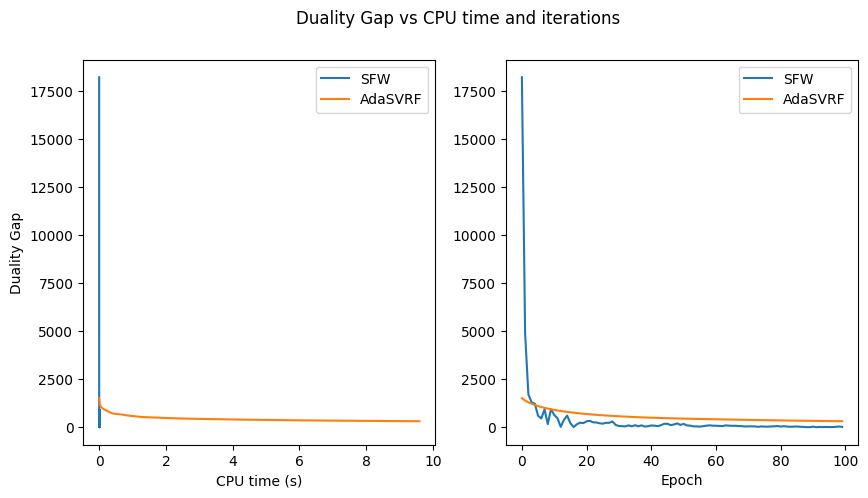

In [ ]:
plotter(times,gaps,'Duality Gap',names)

### California housing dataset

In [ ]:
# Load the California housing dataset
data = fetch_california_housing()

# Features (X) and target variable (y)
X = data.data
y = data.target


scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


n = X_train.shape[0] #number of examples
d = X_train.shape[1] #number of features

In [ ]:
rad = 100
initial_regression = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))


sfw_results = SFW(initial_regression, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_regression, T=epochs, K = 5, clip = False, radius = rad)

In [ ]:
algs = [sfw_results,ada_results]

for i,alg in enumerate(algs):
  print(f"MSE {names[i]}: {f(alg[0])}")

MSE SFW: 5.155082835995103
MSE AdaSVRF: 645.3002793636168


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SFW: 1.2987012987012987
L1-norm of the parameters for AdaSVRF: 44.182678822237584


In [ ]:
times = []
gaps = []
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

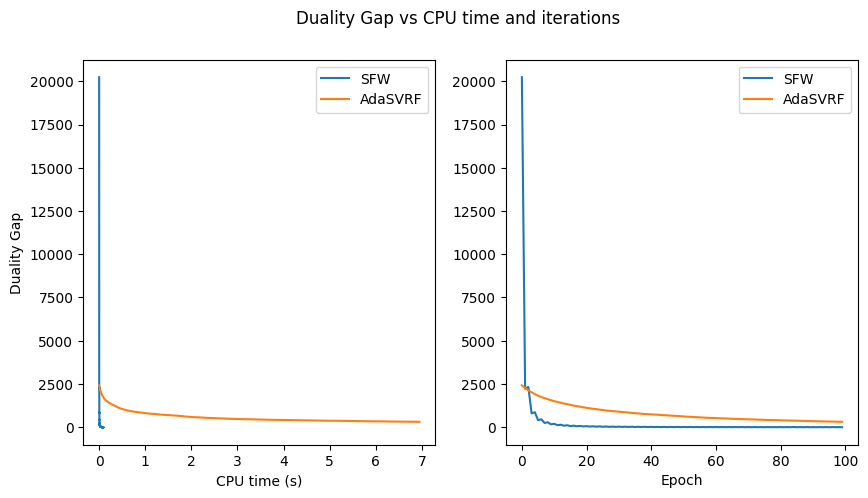

In [ ]:
plotter(times,gaps,'Duality Gap',names)

#Non-Convex Objectives

##Regularized Logistic Regression


In [ ]:
# Define the Lasso Logistic Regression (L1-Norm penalty) loss function and its gradient

def f(w):
    z = X_test.dot(w)
    return np.mean(np.log(1 + np.exp(-y_test * z)))

def f_grad(w):
    z = X_train.dot(w)
    return -(X_train.T.dot(y_train * np.exp(-y_train * z))) / (np.sum(np.exp(-y_train * z)) + 1e-6)

def f_grad_stochastic(w, idx):
    z = X_train[idx].dot(w)
    return -(1/len(idx))*(X_train[idx].T.dot(y_train[idx] * np.exp(-y_train[idx] * z))) / (1+ np.sum(np.exp(-y_train[idx] * z)) + 1e-6)

In [ ]:
def f(w, alpha=0.001):
    z = X_train.dot(w)
    # Add L2 regularization term to the loss function
    return np.mean(np.log(1 + np.exp(-y_train * z))) + alpha * np.sum(np.abs(w))

def f_grad(w, alpha=0.001):
    z = X_train.dot(w)
    # Add L2 regularization term to the gradient
    return -(X_train.T.dot(y_train * np.exp(-y_train * z))) / (np.sum(np.exp(-y_train * z)) + 1e-6) + np.sign(w) * alpha

def f_grad_stochastic(w, idx, alpha=0.001):
    z = X_train[idx].dot(w)
    # Add L2 regularization term to the stochastic gradient
    return -(X_train[idx].T.dot(y_train[idx] * np.exp(-y_train[idx] * z))) / (np.sum(np.exp(-y_train[idx] * z)) + 1e-6) + np.sign(w) * alpha

In [ ]:
def logistic_accuracy(w):
  y_pred_proba = 1 / (1 + np.exp(-X_test.dot(w)))
  y_pred_class = (y_pred_proba > 0.5).astype(int)
  accuracy = np.mean(y_pred_class == y_test)
  return accuracy

### California housing Dataset





In [ ]:
# Load the California housing dataset
data = fetch_california_housing()

# Features (X) and target variable (y)
X = data.data

# # Choose a threshold (mean) for binary classification
threshold = np.mean(data.target)
y = (data.target > threshold).astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

n = X_train.shape[0] #number of examples
d = X_train.shape[1] #number of features

In [ ]:
rad = 100
initial_logistic = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sfw_results = SFW(initial_logistic, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_logistic, T=epochs, K = 5, clip = False, radius = rad)

In [ ]:
algs = [sfw_results,ada_results]

for i,alg in enumerate(algs):
  print(f"Accuracy {names[i]}: {logistic_accuracy(alg[0])}")

Accuracy SFW: 0.5588662790697675
Accuracy AdaSVRF: 0.5164728682170543


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")

L1-norm of the parameters for SFW: 2.1048109965635744
L1-norm of the parameters for AdaSVRF: 27.116263599259902


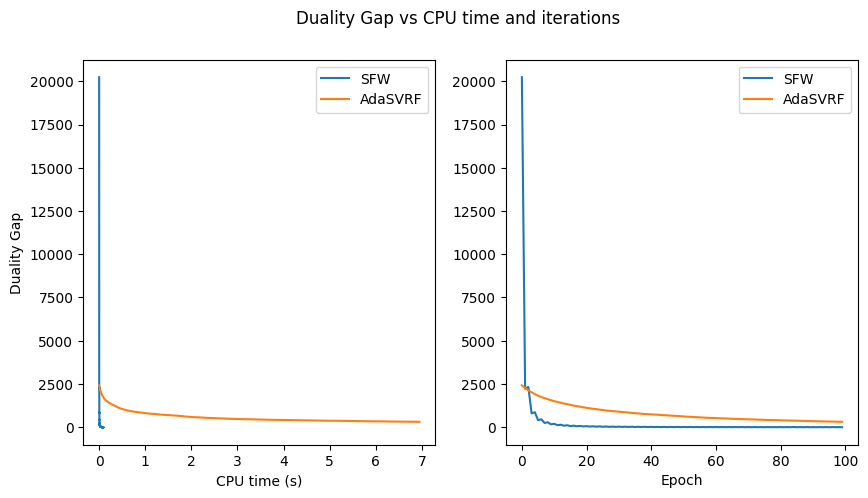

In [ ]:
plotter(times,gaps,'Duality Gap',names)

### Breast Cancer Dataset

In [ ]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = data.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


n = X_train.shape[0] #number of examples
d = X_train.shape[1] #number of features

In [ ]:
rad = 100
initial_logistic = sample_l1_ball(d, size=1, radius=rad)
epochs = 100
Kt = int(round(n/25,0))
b = int(np.round(n/10))

sfw_results = SFW(initial_logistic, epochs, n, Kt, rad)
ada_results = AdaSVRF(m = n,x = initial_logistic, T=epochs, K = 5, clip = False, radius = rad)


In [ ]:
algs = [sfw_results,ada_results]

for i,alg in enumerate(algs):
  print(f"Accuracy {names[i]}: {logistic_accuracy(alg[0])}")

Accuracy SFW: 0.8771929824561403
Accuracy AdaSVRF: 0.12280701754385964


In [ ]:
for i,alg in enumerate(algs):
  print(f"L1-norm of the parameters for {names[i]}: {np.sum(np.abs(alg[0]))}")


L1-norm of the parameters for SFW: 37.24941724941725
L1-norm of the parameters for AdaSVRF: 78.43480708402478


In [ ]:
times = []
gaps = []
for alg in algs:
  times.append(alg[1])
  gaps.append(alg[2])

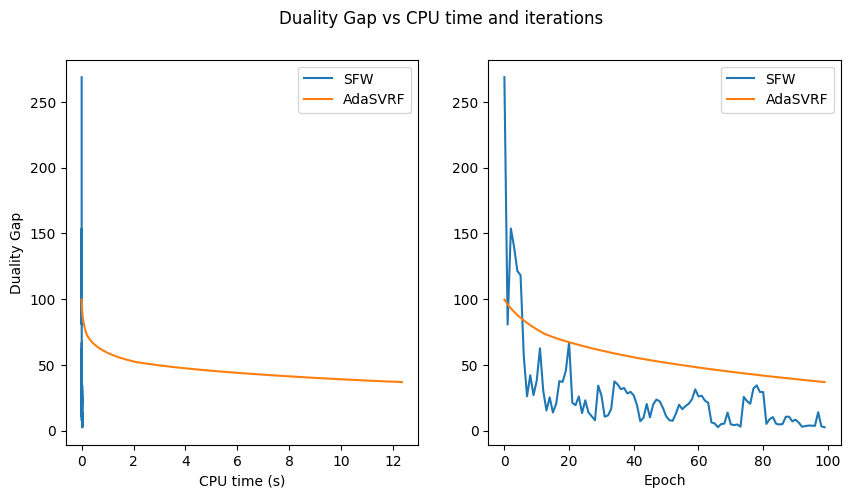

In [ ]:
plotter(times,gaps,'Duality Gap',names)

##Modified SFW

In [ ]:
def SFW_NN(x_bar_1, T, n, Kt, radius=1):
    times = []
    train_loss = []
    test_acc = []
    x_bar = []
    x_bar.append(x_bar_1)

    for t in range(T):

        start = process_time()

        # Uniformly pick the indices of the units
        Q_t = np.random.choice(n, size=Kt, replace=False)

        # Computes the search direction
        v = f_grad_stochastic(x_bar[t], Q_t)
        w = lmo(v,radius)

        # eta computation
        eta = 2/(t+2)

        # Update the iterate
        x_bar.append(x_bar[t] + eta * (w - x_bar[t]))

        # Performance Evaluations for Graphs

        # cpu time
        end = process_time()
        times.append(end-start)

        # train loss
        f_prop_train= forward_propagation(X_train, x_bar[t+1])
        y_train_pred = f_prop_train[3]
        train_loss.append(compute_loss(y_train_pred, y_train))

        # test accuracy
        f_prop_test = forward_propagation(X_test, x_bar[t+1])
        y_test_pred = f_prop_test[3]
        y_test_class = (y_test_pred > 0.5).astype(int)
        test_acc.append(np.mean(y_test_class==y_test))

    index = np.random.choice(range(T))
    return x_bar[index], times, train_loss, test_acc

##Modified AdaSVRF

In [ ]:
#lmo for multidimensional weights array v
def lmo_ADA(v, radius=1):
    x = np.zeros_like(v)
    for i in range(len(v)):
        idx1 = np.argmin(v[i])
        idx2 = np.unravel_index(np.argmax(v[i]), v[i].shape)
        if v[i][np.unravel_index(idx1, v[i].shape)] <= -v[i][idx2]:
            x[i][np.unravel_index(idx1, v[i].shape)] = radius
        else:
            x[i][idx2] = -radius
    return x

In [ ]:
def forward_propagation_ADA(X_train, parameters):
    W1, b1, W2, b2 = parameters[0], parameters[1], parameters[2], parameters[3]
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return np.array([Z1, A1, Z2, A2],dtype=object)

def backward_propagation_ADA(X_train, y_train, cache, parameters):
    m = X_train.shape[0]
    Z1, A1, Z2, A2 = cache[0], cache[1], cache[2], cache[3]
    W1, W2 = parameters[0], parameters[2]
    dZ2 = A2 - y_train
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X_train)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return np.array([dW1, db1, dW2, db2],dtype=object)

def compute_loss_ADA(A2, y_train):
    m = y_train.shape[1]
    loss = -np.sum(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2)) / m
    return np.squeeze(loss)

def f_grad_ADA(parameters):
  cache = forward_propagation(X_train, parameters)
  gradients = backward_propagation(X_train, y_train, cache, parameters)
  return gradients

def f_grad_stochastic_ADA(parameters, indices):
    X_mini = X_train[indices, :]
    Y_mini = y_train[:, indices]
    cache = forward_propagation(X_mini, parameters)
    gradients = backward_propagation(X_mini, Y_mini, cache, parameters)
    return gradients

In [ ]:
def update_H_NN(l):

  H = np.zeros(len(l[0]))

  for element in l:
    for j in range(len(element)):
      H[j] = H[j] + np.sqrt(np.sum(np.square(element[j])))

  return H

In [ ]:
def AdaSVRF_NN(m,x,T,K):

  H = 0
  grad_list = []
  time_list = []
  train_loss= []
  test_acc = []

  x_prev = np.copy(x)

  for t in range(T):

    start = process_time()

    step = compute_step(t)

    if(check_t(t)):
      x_hat = np.copy(x)
      grad = f_grad_ADA(x_hat)
      snapshot = np.copy(grad)
    else:
      x_hat = np.copy(x_prev)

      b = compute_bt(t,K)
      indexes = np.random.randint(low=1, high=m, size=b)

      grad = snapshot + f_grad_stochastic_ADA(x,indexes) - f_grad_stochastic_ADA(x_hat,indexes)

    x_prev = np.copy(x_hat)

    grad_list.append(grad)

    H = update_H_NN(grad_list)

    rate = compute_rate(t)
    step = compute_step(t)

    y = np.copy(x)

    for k in range(K):

      for i,parameter in enumerate(x_hat):

        Q = grad[i] + (1/rate) * H[i] * (y[i]-x[i])

        v = lmo_ADA(Q)

        # This is done to avoid the repetition of the computation
        diff = y[i]-v

        step = np.min([step, np.dot(Q.flatten(),diff.flatten())/(np.dot(diff.flatten(),H[i]*diff.flatten())+0.000001)])

        # Here - and not + beacause (v-y) = -(y-v)
        y[i] = y[i] - step*diff

    x = np.copy(y)

    end = process_time()
    time_list.append(end-start)

    # train loss
    f_prop_train= forward_propagation_ADA(X_train, x)
    y_train_pred = f_prop_train[3]
    train_loss.append(compute_loss_ADA(y_train_pred, y_train))

    # test accuracy
    f_prop_test = forward_propagation_ADA(X_test, x)
    y_test_pred = f_prop_test[3]
    y_test_class = (y_test_pred > 0.5).astype(int)
    test_acc.append(np.mean(y_test_class==y_test))

  return x, time_list, train_loss, test_acc

## Shallow Neural Network

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_parameters(n_features, n_hidden, n_output):
    W1_shape = (n_hidden, n_features)
    b1_shape = (n_hidden, 1)
    W2_shape = (n_output, n_hidden)
    b2_shape = (n_output, 1)
    W1 = sample_l1_ball(np.prod(W1_shape), size=1).reshape(W1_shape)
    b1 = sample_l1_ball(np.prod(b1_shape), size=1).reshape(b1_shape)
    W2 = sample_l1_ball(np.prod(W2_shape), size=1).reshape(W2_shape)
    b2 = sample_l1_ball(np.prod(b2_shape), size=1).reshape(b2_shape)
    return np.array([W1, b1, W2, b2],dtype=object)

def forward_propagation(X_train, parameters):
    W1, b1, W2, b2 = parameters[0], parameters[1], parameters[2], parameters[3]
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return np.array([Z1, A1, Z2, A2],dtype=object)

def backward_propagation(X_train, y_train, cache, parameters):
    m = X_train.shape[0]
    Z1, A1, Z2, A2 = cache[0], cache[1], cache[2], cache[3]
    W1, W2 = parameters[0], parameters[2]
    dZ2 = A2 - y_train
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X_train)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    return np.array([dW1, db1, dW2, db2],dtype=object)

def compute_loss(A2, y_train):
    m = y_train.shape[1]
    loss = -np.sum(y_train * np.log(A2) + (1 - y_train) * np.log(1 - A2)) / m
    return np.squeeze(loss)

def f_grad_stochastic(parameters, indices):
    X_mini = X_train[indices, :]
    Y_mini = y_train[:, indices]
    cache = forward_propagation(X_mini, parameters)
    gradients = backward_propagation(X_mini, Y_mini, cache, parameters)
    return gradients

In [ ]:
#lmo for multidimensional weights array v
def lmo(v, radius=1):
    x = [np.zeros_like(v_i) for v_i in v]
    for i in range(len(v)):
        idx1 = np.argmin(v[i])
        idx2 = np.unravel_index(np.argmax(v[i]), v[i].shape)
        if v[i][np.unravel_index(idx1, v[i].shape)] <= -v[i][idx2]:
            x[i][np.unravel_index(idx1, v[i].shape)] = radius
        else:
            x[i][idx2] = -radius
    return x

In [ ]:
def accuracy_NN(w):
  cache = forward_propagation(X_test, w)
  predictions = cache[3]

  binary_predictions = (predictions > 0.5).astype(int)

  accuracy=np.mean(binary_predictions==y_test)

  return accuracy

### Diabetes dataset



In [ ]:
# Load the Diabetes dataset
diabetes = datasets.load_diabetes()


X = data.data
y = (data.target == 0).astype(int) # To advantage binary classification

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

n_features = X_train.shape[1]
n_hidden = 2   # Number of neurons in the hidden layer
n_output = 1   # Number of output neurons (binary classification)
n = X_train.shape[0]

parameters = initialize_parameters(n_features, n_hidden, n_output)


In [ ]:
rad = 1
initial_support = sample_l1_ball(n_features, size=1, radius=rad)
epochs = 3*100
Kt = int(round(n/25,0))
b = int(np.round(n/10))


sfw_results_NN = SFW_NN(parameters, epochs, n, Kt, rad)
ada_results_NN = AdaSVRF_NN(m = n,x = parameters, T=epochs, K = 5)


In [ ]:
algs_NN = [sfw_results_NN,ada_results_NN]

for i,alg in enumerate(algs_NN):
  print(f"Accuracy {names[i]}: {accuracy_NN(alg[0])}")

Accuracy SFW: 0.9385964912280702
Accuracy AdaSVRF: 0.9473684210526315


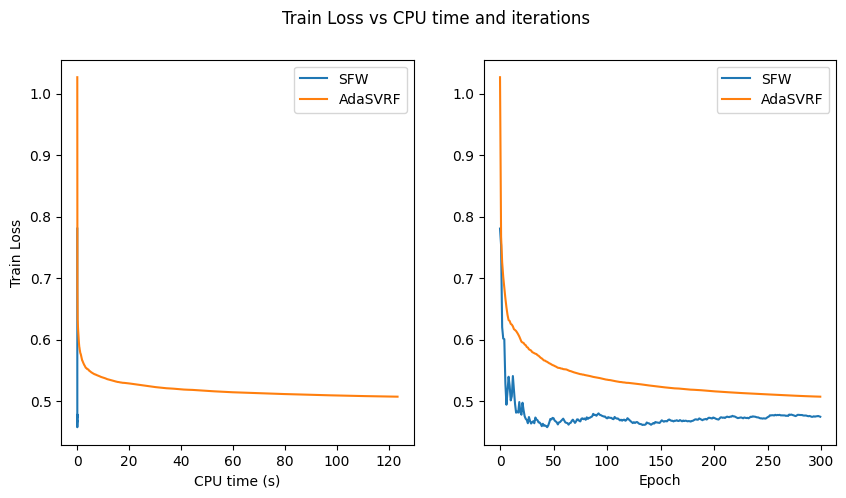

In [ ]:
times = []
losses = []
for alg in algs_NN:
  times.append(alg[1])
  losses.append(alg[2])
plotter(times,losses,'Train Loss',names)

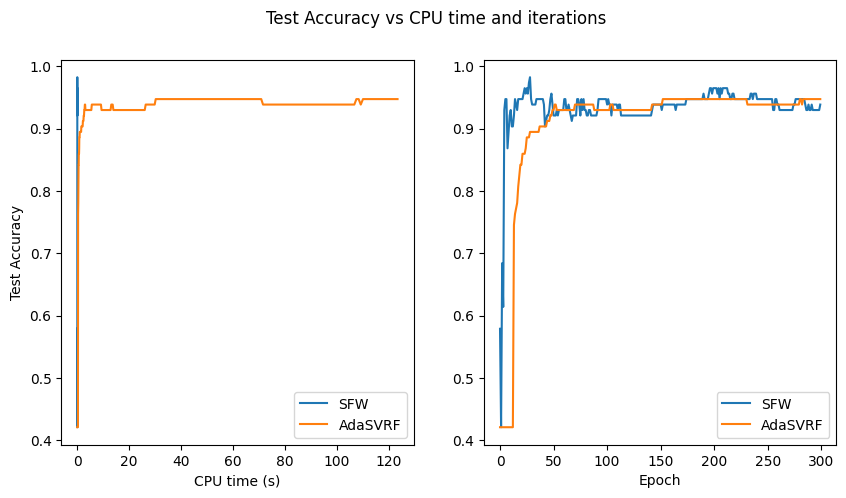

In [ ]:
times = []
accs = []
for alg in algs_NN:
  times.append(alg[1])
  accs.append(alg[3])
plotter(times,accs,'Test Accuracy',names)

### Breast cancer dataset

In [ ]:
# Load the breast cancer dataset
data = datasets.load_breast_cancer()
X = data.data
y = (data.target == 0).astype(int) #To advantage binary classification

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

n_features = X_train.shape[1]
n_hidden = 2   # Number of neurons in the hidden layer
n_output = 1   # Number of output neurons (binary classification)
n = X_train.shape[0]

parameters = initialize_parameters(n_features, n_hidden, n_output)


In [ ]:
rad = 1
initial_support = sample_l1_ball(n_features, size=1, radius=rad)
epochs = 3*100
Kt = int(round(n/25,0))
b = int(np.round(n/10))


sfw_results_NN = SFW_NN(parameters, epochs, n, Kt, rad)
ada_results_NN = AdaSVRF_NN(m = n,x = parameters, T=epochs, K = 5)


In [ ]:
algs_NN = [sfw_results_NN,ada_results_NN]

for i,alg_NN in enumerate(algs_NN):
  print(f"Accuracy {names[i]}: {accuracy_NN(alg_NN[0])}")

Accuracy SFW: 0.9736842105263158
Accuracy AdaSVRF: 0.9824561403508771


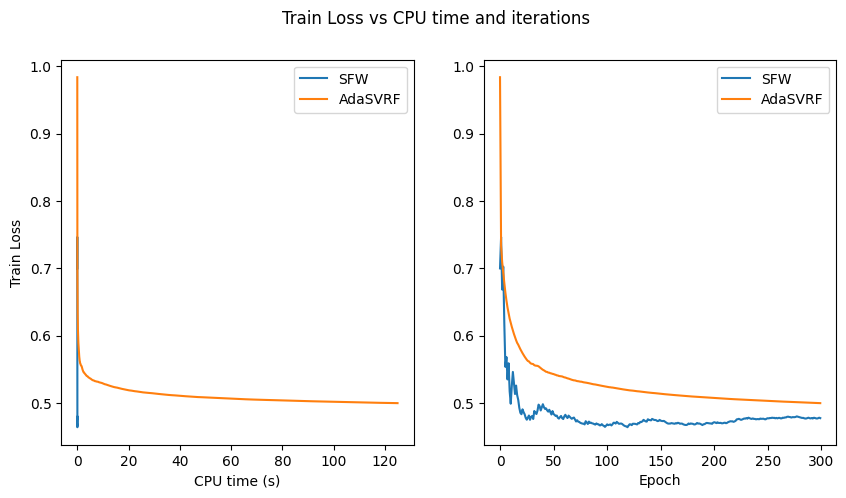

In [ ]:
times = []
losses = []
for alg_NN in algs_NN:
  times.append(alg_NN[1])
  losses.append(alg_NN[2])
plotter(times,losses,'Train Loss',names)

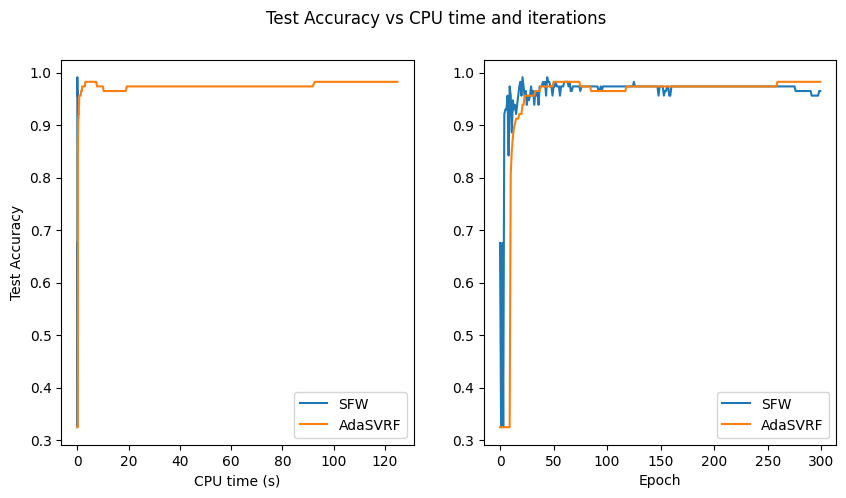

In [ ]:
times = []
accs = []
for alg_NN in algs_NN:
  times.append(alg_NN[1])
  accs.append(alg_NN[3])
plotter(times,accs,'Test Accuracy',names)